In [20]:
import os
import random
from PIL import Image
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.manifold import TSNE
import base64
import plotly.express as px
import io
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
import cv2

In [2]:
import kagglehub
path = kagglehub.dataset_download("gpiosenka/sports-classification")
train_path = os.path.join(path, "train")
valid_path = os.path.join(path, "valid")
test_path = os.path.join(path, "test")

class_names = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

### Transformácie

In [3]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.GridDropout(ratio=0.5, unit_size_min=20, unit_size_max=50, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

c:\Users\ASUS\anaconda3\envs\torch_gpu\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10996\3346792762.py:7: UserWarning: Argument(s) 'unit_size_min, unit_size_max' are not valid for transform GridDropout
  A.GridDropout(ratio=0.5, unit_size_min=20, unit_size_max=50, p=0.3),


### Prerozdelenie datasetu na train, valid a test datasety podľa nového pomer (≈8:1:1)

In [4]:
class SportDataset(Dataset):
    def __init__(self, all_samples, class_to_idx, indices, transform=None):
        self.samples = [(all_samples[i][0], class_to_idx[all_samples[i][1]]) for i in indices]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        image = np.array(Image.open(img_path).convert("RGB"))
        raw_img = image

        if self.transform:
            image = self.transform(image=image)["image"]

        return raw_img, image, label  

def dataset_split(root, split_pct=0.2, seed=42):
    random.seed(seed)

    all_samples = []
    for split_folder in ["train", "valid", "test"]:
        split_path = os.path.join(root, split_folder)
        if not os.path.exists(split_path):
            continue
        for class_name in os.listdir(split_path):
            class_folder = os.path.join(split_path, class_name)
            if not os.path.isdir(class_folder):
                continue
            for fname in os.listdir(class_folder):
                if fname in os.listdir(class_folder):
                    if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif", ".gif")):
                        all_samples.append((os.path.join(class_folder, fname), class_name))

    classes = sorted({cls for _, cls in all_samples})
    class_to_idx = {cls: i for i, cls in enumerate(classes)}

    class_to_indices = defaultdict(list)
    for idx, (_, cls) in enumerate(all_samples):
        class_to_indices[cls].append(idx)

    train_indices = []
    val_indices = []
    test_indices = []

    for cls, idxs in class_to_indices.items():
        random.shuffle(idxs)
        n_total = len(idxs)
        n_candidate = max(1, int(n_total * split_pct))
        n_val = n_candidate // 2
        n_test = n_candidate - n_val
        n_train = n_total - n_candidate

        train_indices.extend(idxs[:n_train])
        val_indices.extend(idxs[n_train:n_train+n_val])
        test_indices.extend(idxs[n_train+n_val:])

    train_dataset = SportDataset(all_samples, class_to_idx, train_indices, transform=train_transform)
    valid_dataset = SportDataset(all_samples, class_to_idx, val_indices, transform=test_transform)
    test_dataset = SportDataset(all_samples, class_to_idx, test_indices, transform=test_transform)

    return train_dataset, valid_dataset, test_dataset


In [5]:
train_dataset, valid_dataset, test_dataset = dataset_split(path)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0)

### Pomocné funkcie na vyhodnocovanie

In [6]:
def plot_classwise_accuracy(model, dataloader, class_names, device="cuda"):
    model.eval()
    model.to(device)
    correct_dict = {cls: 0 for cls in class_names}
    total_dict = {cls: 0 for cls in class_names}

    with torch.no_grad():
        for raw, imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            for l, p in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                total_dict[class_names[l]] += 1
                if l == p:
                    correct_dict[class_names[l]] += 1

    class_acc = {cls: correct_dict[cls]/total_dict[cls] 
                 for cls in class_names if total_dict[cls] > 0}

    df = pd.DataFrame(list(class_acc.items()), columns=["class", "accuracy"])
    df = df.sort_values("accuracy", ascending=False)

    plt.figure(figsize=(25, 10))
    plt.bar(df["class"], df["accuracy"])
    plt.xticks(rotation=90)
    plt.ylabel("Accuracy")
    plt.title("Class-wise accuracy")
    plt.show()

    return df

def topk_confusion_matrix(model, dataloader, class_names, k=5, device="cuda"):
    model.eval()
    model.to(device)
    num_classes = len(class_names)
    cm =np.zeros((num_classes, num_classes), dtype=int)
    with torch.no_grad():
        for raw, imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            topk_preds = outputs.topk(k, dim=1).indices

            for i, label in enumerate(labels):
                if label.item() not in topk_preds[i]:
                    cm[label.item(), topk_preds[i,0].item()] += 1
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Reds')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Top-{k} confusion matrix")
    plt.show()
    return cm 

def tsne_embedding(model, dataloader, class_names, device="cuda", max_samples=2000):
    features = []
    labels_all = []

    model.eval()
    with torch.no_grad():
        count = 0
        for raw, imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)

            x = model.conv1(imgs)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)

            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)

            x = model.avgpool(x)        
            x = torch.flatten(x, 1)    

            features.append(x.cpu())
            labels_all.append(labels.cpu())

            count += imgs.size(0)
            if count >= max_samples:
                break

    features = torch.cat(features)[:max_samples].numpy()
    labels_all = torch.cat(labels_all)[:max_samples].numpy()

    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(12,20))
    scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels_all, cmap='tab20', s=15, alpha=0.8)
    plt.colorbar(scatter, ticks=range(len(class_names)))
    plt.title("t-SNE embedding of model features")
    plt.show()     

#### Pomocné funkcie pre interaktívny graf

In [ ]:
def tensor_to_pil(img_input):
    if isinstance(img_input, torch.Tensor):
        img_array = img_input.cpu().numpy()
    else:
        img_array = img_input

    if img_array.ndim == 3 and img_array.shape[0] in [1,3]:
        img_array = np.transpose(img_array, (1,2,0))

    if img_array.dtype in [np.float32, np.float64]:
        img_array = np.clip(img_array, 0, 1)
        img_array = (img_array*255).astype(np.uint8)

    if img_array.ndim == 2:
        img_array = np.stack([img_array]*3, axis=-1)

    return Image.fromarray(img_array)


def tsne_embedding_click_view(model, dataloader, class_names, device="cuda", max_samples=2000):

    features = []
    labels_all = []
    images_raw = []

    model.eval()
    with torch.no_grad():
        count = 0
        for raw, imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            x = model.conv1(imgs)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)
            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            x = model.avgpool(x)
            x = torch.flatten(x, 1)

            features.append(x.cpu())
            labels_all.append(labels.cpu())
            images_raw.extend(raw)

            count += imgs.size(0)
            if count >= max_samples:
                break

    features = torch.cat(features)[:max_samples].numpy()
    labels_all = torch.cat(labels_all)[:max_samples].numpy()
    images_raw = images_raw[:max_samples]

    tsne = TSNE(n_components=2, random_state=42)
    coords = tsne.fit_transform(features)

    scatter = go.FigureWidget(
        data=[
            go.Scatter(
                x=coords[:, 0],
                y=coords[:, 1],
                mode="markers",
                marker=dict(color=labels_all, colorscale="Turbo", size=6),
                customdata=np.arange(len(images_raw))
            )
        ],
        layout=go.Layout(
            title="Interactive t-SNE (click a point)"
        )
    )

    image_widget = widgets.Image(format='png', width=256, height=256)
    title_widget = widgets.HTML("<b>Klikni na bod → zobrazí sa obrázok</b>")

    display(title_widget)
    display(widgets.HBox([scatter, image_widget]))

    scatter.data[0].on_click(
        lambda trace, points, state: on_click_point(
            points,
            images_raw,
            labels_all,
            class_names,
            image_widget,
            title_widget
        )
    )


def on_click_point(points, images_raw, labels_all, class_names, image_widget, title_widget):
    if len(points.point_inds) == 0:
        return

    idx = points.point_inds[0]

    pil_img = tensor_to_pil(images_raw[idx])
    buf = io.BytesIO()
    pil_img.save(buf, format='PNG')
    image_widget.value = buf.getvalue()

    title_widget.value = f"<b>Label:</b> {class_names[labels_all[idx]]}"

#### Pomocné funkcie Grad-CAM 

In [79]:
def get_two_samples_same_class(test_loader, chosen_class=None):

    all_samples = []
    for batch in test_loader:
        raws, imgs, labels = batch
        for r, i, l in zip(raws, imgs, labels):
            all_samples.append((r, i, l.item()))
    
    if chosen_class is None:
        classes = [l for _, _, l in all_samples]
        chosen_class = random.choice(classes)
   
    same_class_samples = [(r, i, l) for r, i, l in all_samples if l == chosen_class]
        
    sample1, sample2 = random.sample(same_class_samples, 2)
    
    raw1, img_tensor1, label1 = sample1
    raw2, img_tensor2, label2 = sample2
    
    img_tensor1 = img_tensor1.unsqueeze(0)
    img_tensor2 = img_tensor2.unsqueeze(0)
    
    return (raw1, img_tensor1, label1), (raw2, img_tensor2, label2)


def to_hwc_uint8(img):
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()

    if img.max() <= 1.0:
        img = img * 255

    img = img.astype(np.uint8)

    if img.ndim == 3:
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        elif img.shape[1] == 3:
            img = np.transpose(img, (0, 2, 1))

    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    if img.shape[2] == 1:
        img = np.repeat(img, 3, axis=2)

    return img

def show_gradcam_pair(img1, mask1, img2, mask2, alpha=0.5):
    img1 = to_hwc_uint8(img1)
    img2 = to_hwc_uint8(img2)

    H, W = img1.shape[:2]

    def process_mask(mask):
        if isinstance(mask, torch.Tensor):
            mask = mask.detach().cpu().numpy()
        mask = cv2.resize(mask, (W, H))
        mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)
        return mask

    mask1 = process_mask(mask1)
    mask2 = process_mask(mask2)

    heatmap1 = plt.cm.jet(mask1)[:, :, :3]
    heatmap1 = (heatmap1 * 255).astype(np.uint8)
    heatmap2 = plt.cm.jet(mask2)[:, :, :3]
    heatmap2 = (heatmap2 * 255).astype(np.uint8)

    superimposed1 = cv2.addWeighted(img1, 1 - alpha, heatmap1, alpha, 0)
    superimposed2 = cv2.addWeighted(img2, 1 - alpha, heatmap2, alpha, 0)

    superimposed1 = np.rot90(superimposed1, k=3)
    superimposed2 = np.rot90(superimposed2, k=3)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Sample 1")
    plt.imshow(superimposed1)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Sample 2")
    plt.imshow(superimposed2)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

class GradCAM:
      def __init__(self, model, target_layer):
          
            self.model = model
            self.model.eval()
            self.target_layer = target_layer

            self.activations = None
            self.gradients = None

            def forward_hook(module, input, output):
                  self.activations = output.detach()
          
            def backward_hook(module, grad_input, grad_output):
                  self.gradients = grad_output[0].detach()

            target_layer.register_forward_hook(forward_hook)
            target_layer.register_backward_hook(backward_hook)
      
      def __call__(self, x, class_idx=None):

            output = self.model(x)
            if class_idx is None:
                  class_idx = output.argmax(dim=1).item()

            self.model.zero_grad()
            loss = output[0, class_idx]
            loss.backward()

            pooled_gradients = torch.mean(self.gradients, dim=[0,2,3])
            activations = self.activations[0]

            for i in range(activations.shape[0]):
                  activations[i, :, :] *= pooled_gradients[i]

            heatmap = activations.sum(dim=0).cpu().numpy()
            heatmap = np.maximum(heatmap, 0)
            heatmap = heatmap / np.max(heatmap)
            return heatmap

# Experimenty

In [8]:
def accuracy(preds, labels):
    return (preds.argmax(dim=1) == labels).float().mean().item()

def train_model(model, train_loader, val_loader, criterion, optimizer, model_name,
                scheduler=None, num_epochs=20, patience=5, device="cuda"):
    model.to(device)

    best_val_loss = float("inf")
    patience_counter = 0

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        model.train()
        train_loss = 0
        train_acc = 0

        loop = tqdm(train_loader, desc="Training", leave=False)
        for raw, imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(outputs, labels)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        model.eval()
        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for raw, imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)
            
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        if scheduler:
            scheduler.step()

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.4f} |"
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            os.makedirs("best_models", exist_ok=True)
            torch.save(model.state_dict(), f"best_models/{model_name}.pth")
        else:
            patience_counter += 1

            if patience_counter >= patience:
                print("Early stop!")
                break
            
    return history

### AlexNet

#### Definovaná trieda pre AlexNet

In [11]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#### Tréning

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 100

model = AlexNet(num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    model_name="alexnet",
    scheduler=scheduler,
    num_epochs=100,
    patience=10,
    device=device
)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3684\1873373777.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  alexnet.load_state_dict(torch.load("best_model.pth", map_locat

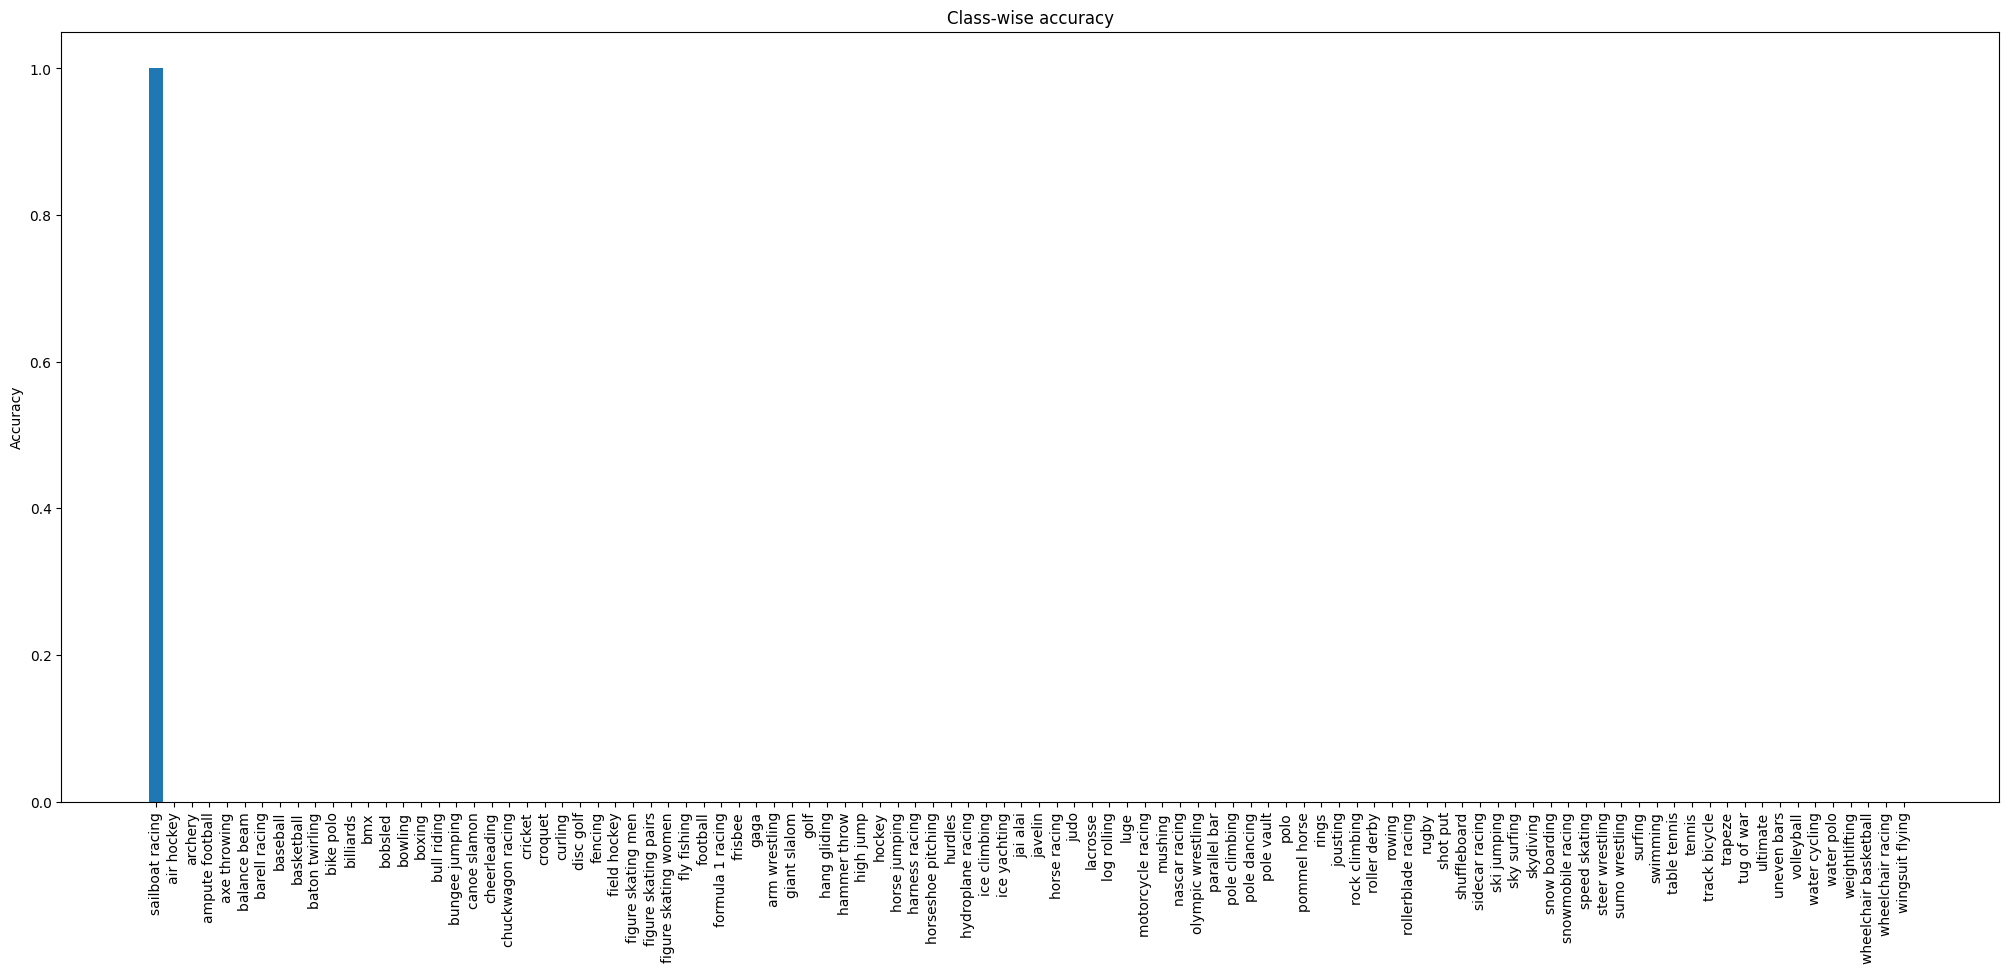

,class,accuracy
72,sailboat racing,1.000000
0,air hockey,0.000000
2,archery,0.000000
1,ampute football,0.000000
4,axe throwing,0.000000
5,balance beam,0.000000
6,barell racing,0.000000
7,baseball,0.000000
8,basketball,0.000000
9,baton twirling,0.000000


In [10]:
alexnet = AlexNet()
alexnet.load_state_dict(torch.load("best_model.pth", map_location="cpu"))
per_cls_acc = plot_classwise_accuracy(model, test_loader, class_names)
per_cls_acc.style.set_table_attributes('style="display:inline-block; height:300px; overflow:auto;"')

### ResNet18

In [9]:
num_classes = 100

resnet18 = models.resnet18(weights="IMAGENET1K_V1")
resnet18.fc = nn.Linear(512, num_classes)
resnet18 = resnet18.to("cuda" if torch.cuda.is_available() else "cpu")

optimizer = Adam(resnet18.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
history = train_model(
            resnet18, 
            train_loader, 
            valid_loader, 
            criterion=nn.CrossEntropyLoss(),
            optimizer=optimizer,
            model_name="resnet18",
            scheduler=scheduler,
            num_epochs=20,
            patience=5,
            device="cuda"
            )


Epoch 1/20


Training:   0%|          | 0/364 [00:00<?, ?it/s]

Train Loss: 2.4976 | Train Acc: 50.2938 |Val Loss: 0.9942 | Val Acc: 80.5667

Epoch 2/20


Train Loss: 0.9046 | Train Acc: 81.9072 |Val Loss: 0.5568 | Val Acc: 88.2812

Epoch 3/20


Train Loss: 0.5180 | Train Acc: 89.7703 |Val Loss: 0.4054 | Val Acc: 91.0438

Epoch 4/20


Train Loss: 0.3372 | Train Acc: 93.1080 |Val Loss: 0.3581 | Val Acc: 91.4062

Epoch 5/20


Train Loss: 0.2415 | Train Acc: 95.3316 |Val Loss: 0.3071 | Val Acc: 92.9688

Epoch 6/20


Train Loss: 0.1404 | Train Acc: 97.7784 |Val Loss: 0.2530 | Val Acc: 94.1761

Epoch 7/20


Train Loss: 0.1056 | Train Acc: 98.4289 |Val Loss: 0.2479 | Val Acc: 93.3239

Epoch 8/20


Train Loss: 0.0855 | Train Acc: 98.7637 |Val Loss: 0.2414 | Val Acc: 93.2528

Epoch 9/20


Train Loss: 0.0750 | Train Acc: 98.9698 |Val Loss: 0.2377 | Val Acc: 94.7370

Epoch 10/20


Train Loss: 0.0627 | Train Acc: 99.1587 |Val Loss: 0.2328 | Val Acc: 94.2472

Epoch 11/20


Train Loss: 0.0468 | Train Acc: 99.3924 |Val Loss: 0.2213 | Val Acc: 94.2472

Epoch 12/20


Train Loss: 0.0445 | Train Acc: 99.5364 |Val Loss: 0.2118 | Val Acc: 94.9574

Epoch 13/20


Train Loss: 0.0387 | Train Acc: 99.5965 |Val Loss: 0.2184 | Val Acc: 94.2472

Epoch 14/20


KeyboardInterrupt: 

In [10]:
resnet18.load_state_dict(torch.load("best_models/resnet18.pth", map_location="cpu"))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10996\2654144043.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load("best_models/resnet18.pth

<All keys matched successfully>

In [17]:
tsne_embedding_click_view(resnet18, test_loader, class_names)

HTML(value='<b>Klikni na bod → zobrazí sa obrázok</b>')

    'data': [{'customdata': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'IFo…

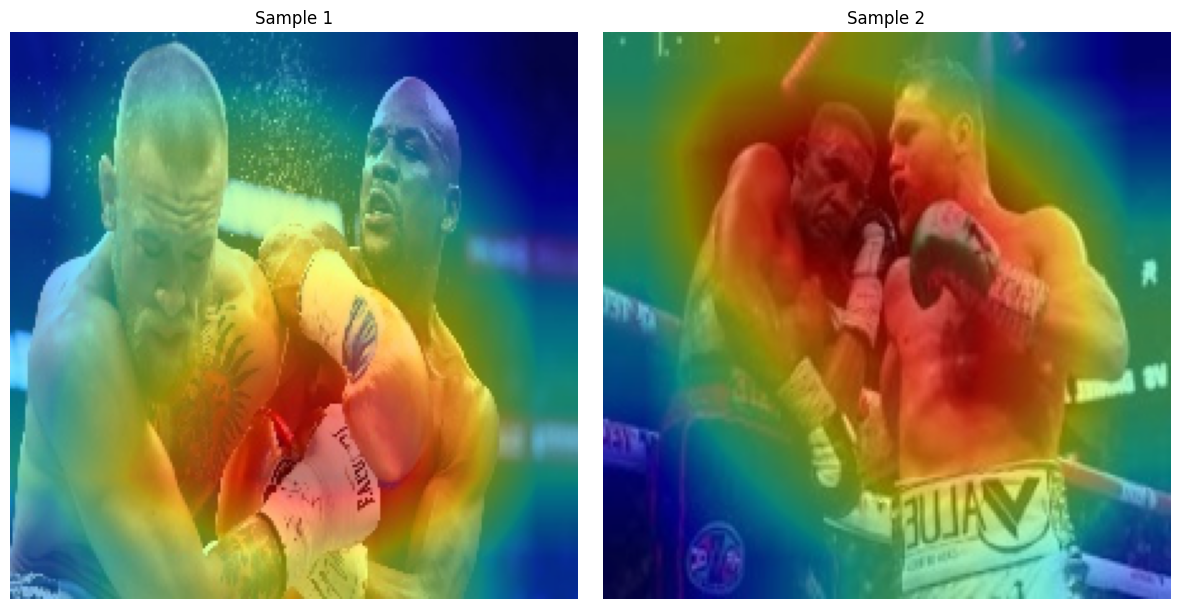

In [83]:
device = "cuda" if torch.cuda.is_available() else "cpu"

(sample1, sample2) = get_two_samples_same_class(test_loader, chosen_class=15)

raw1, img_tensor1, label1 = sample1
raw2, img_tensor2, label2 = sample2

img_tensor1 = img_tensor1.to(device)
img_tensor2 = img_tensor2.to(device)

target_layer = resnet18.layer4[-1]
gradcam = GradCAM(resnet18, target_layer)

mask1 = gradcam(img_tensor1)
mask2 = gradcam(img_tensor2)

raw_np1 = raw1.permute(1, 2, 0).cpu().numpy()
raw_np2 = raw2.permute(1, 2, 0).cpu().numpy()

show_gradcam_pair(raw_np1, mask1, raw_np2, mask2)

### Per-class accuracy

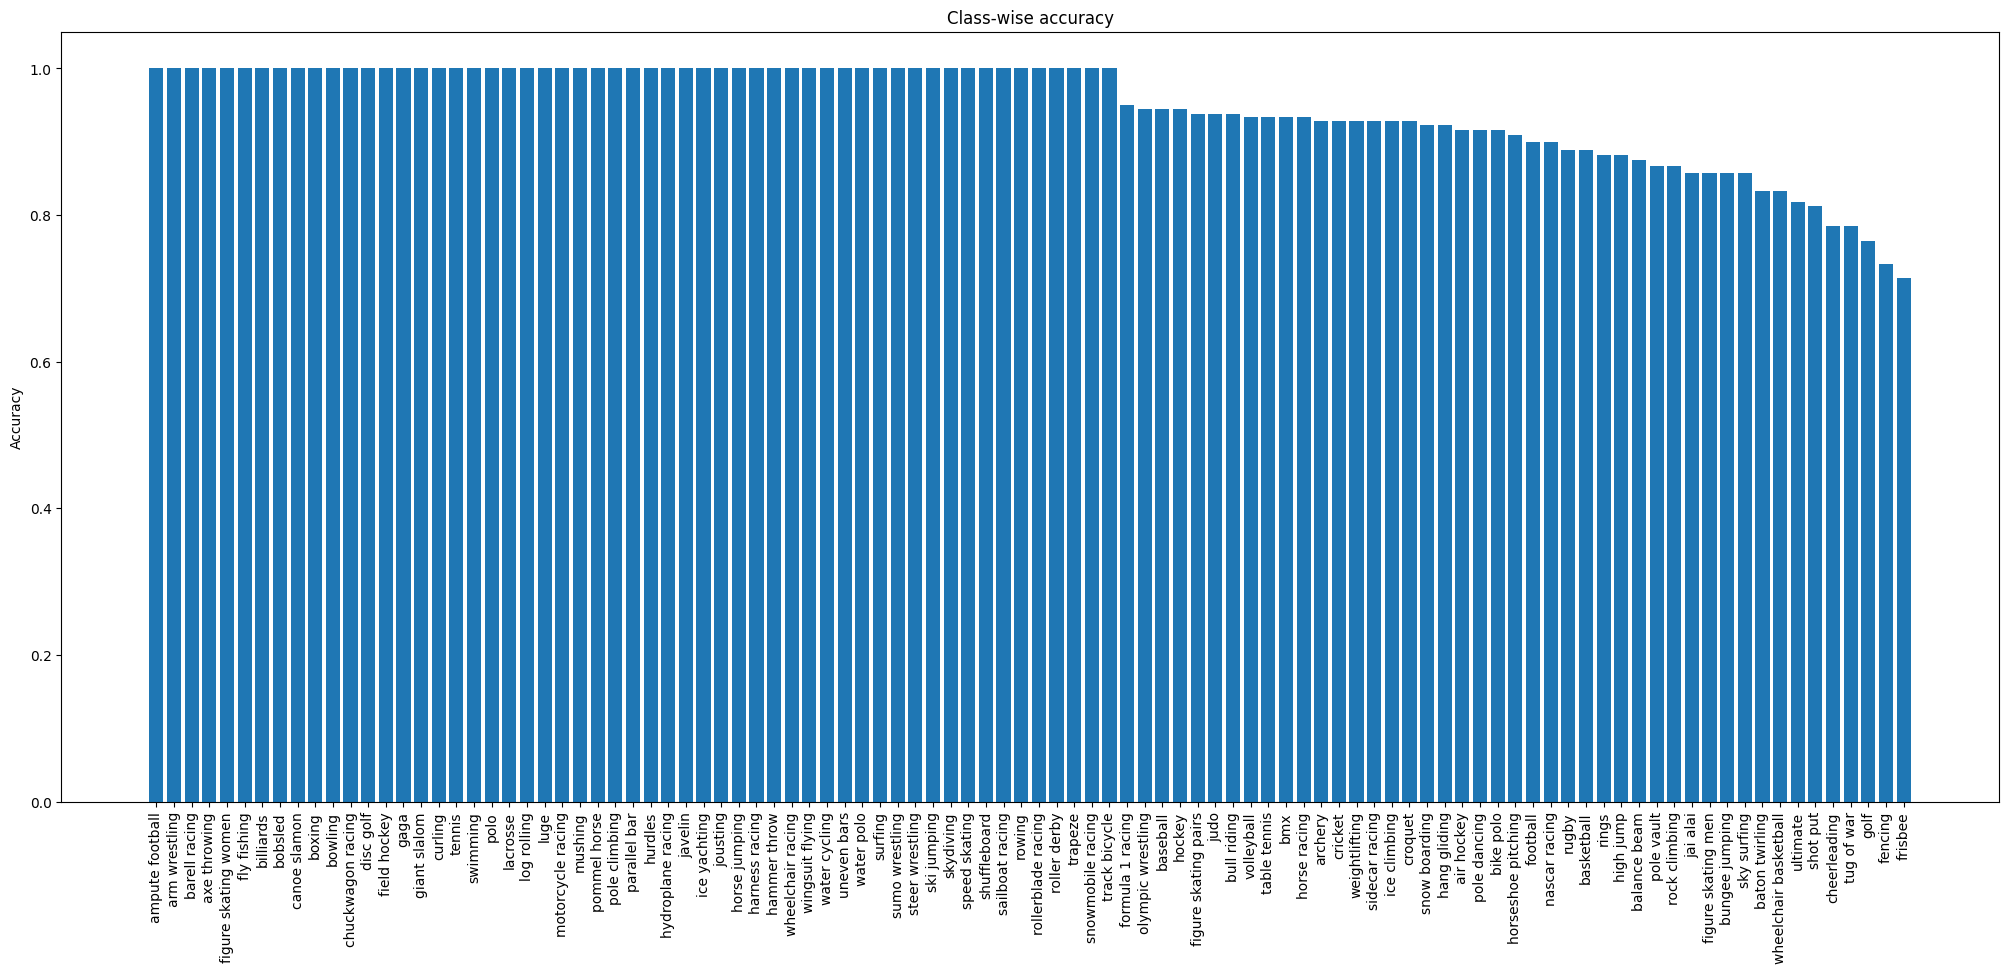

,class,accuracy
1,ampute football,1.000000
3,arm wrestling,1.000000
6,barell racing,1.000000
4,axe throwing,1.000000
29,figure skating women,1.000000
30,fly fishing,1.000000
11,billiards,1.000000
13,bobsled,1.000000
18,canoe slamon,1.000000
15,boxing,1.000000


In [ ]:
per_cls_acc = plot_classwise_accuracy(resnet18, test_loader, class_names)
per_cls_acc.style.set_table_attributes('style="display:inline-block; height:300px; overflow:auto;"')

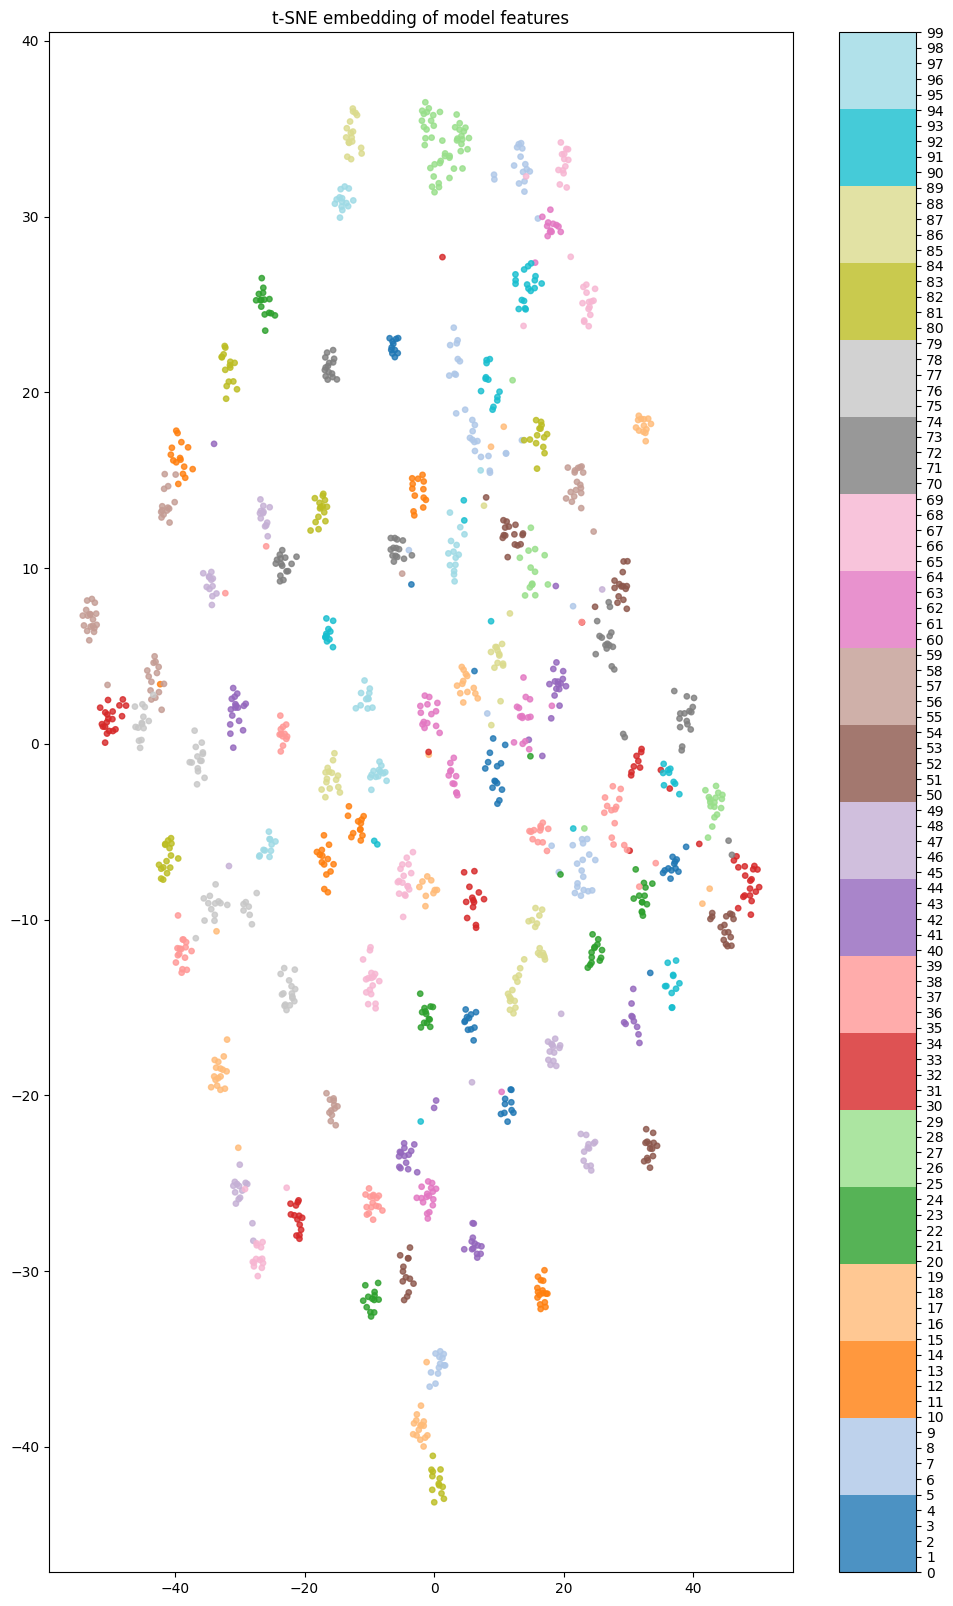

In [ ]:
tsne_embedding(resnet18, test_loader, class_names)